In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
import matplotlib.pyplot as plt
import torchvision.models as models             

from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           
from copy import deepcopy
from mqbench.advanced_ptq import ptq_reconstruction
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(val_loader, model,
             criterion = torch.nn.CrossEntropyLoss().cuda(),device='cuda'):
    s_time = time.time()
    # switch to evaluate mode
    model.eval()
    count,top1,top5,losses = 0,0,0,0
    correct = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images, target = images.to(device), target.to(device)
            # compute output
            output = model(images)
            loss = criterion(output, target)
            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses = losses * count/(count+images.size(0)) + loss * images.size(0)/(count+images.size(0))
            top1 = top1 * count/(count+images.size(0)) + acc1 * images.size(0)/(count+images.size(0))
            top5 = top5 * count/(count+images.size(0)) + acc5 * images.size(0)/(count+images.size(0))
            count += images.size(0)
            #correct += acc1 * images.size(0)
    test_time = time.time() - s_time
    #print(f'correct: {correct}/{count}')
    
    return {'top1':top1,'top5':top5,'loss':losses,'time':test_time}

    

In [3]:
adv_ptq = False
dataset = 'cifar100'
modelname = 'resnet56'
mn = dataset.lower()+ '_' + modelname
model = torch.hub.load("chenyaofo/pytorch-cifar-models", mn, pretrained=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()
model.eval()
torch.manual_seed(0)
np.random.seed(0)
train,test = get_loader(dataset.upper(),batch_size=512,test_batch_size=128)
train.num_workers = 4
test.num_workers = 4
train.pin_in_memory = True
test.pin_in_memory = True

Using cache found in /homes/zdeng/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified
Files already downloaded and verified


In [4]:
evaluate(train,model)

{'top1': tensor([76.0100], device='cuda:0'),
 'top5': tensor([91.9021], device='cuda:0'),
 'loss': tensor(1.0457, device='cuda:0'),
 'time': 6.549895763397217}

In [5]:
evaluate(test,model)

{'top1': tensor([72.6300], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.2946, device='cuda:0'),
 'time': 1.1099143028259277}

In [6]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
stacked_tensor = []
calib_fp_output = []
i = 0
with torch.no_grad():
    for img,label in train:
        i += 1
        # stacked_tensor is to calibrate the model
        # calib_data (part of it, as defined later) is the data to calculate ltilde
        if i<= 2:
            stacked_tensor.append(img)
            
        calib_data.append((img,label))
        calib_fp_output.append(model(img.cuda()))


In [7]:
MPQ_scheme = (2,4,8)
model.eval()

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [8]:
# configuration
ptq_reconstruction_config_init = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 1,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}


ptq_reconstruction_config = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 20000,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
ptq_reconstruction_config = dotdict(ptq_reconstruction_config)
ptq_reconstruction_config_init = dotdict(ptq_reconstruction_config_init)

def getModuleByName(model,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    m = model
    for tok in tokens:
        m = getattr(m,tok)
    return m

for b in MPQ_scheme:
    mqb_fp_model = deepcopy(model)
    
    # MSE calibration on model parameters
    backend = BackendType.Academic
    extra_config = {
        'extra_qconfig_dict': {
            'w_observer': 'MSEObserver',                              # custom weight observer
            'a_observer': 'EMAMSEObserver',                              # custom activation observer
            'w_fakequantize': 'AdaRoundFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'a_fakequantize': 'QDropFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'w_qscheme': {
                'bit': b,                                             # custom bitwidth for weight,
                'symmetry': True,                                    # custom whether quant is symmetric for weight,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
                'pot_scale': False,                                   # custom whether scale is power of two for weight.
            },
            'a_qscheme': {
                'bit': 8,                                             # custom bitwidth for activation,
                'symmetry': False,                                    # custom whether quant is symmetric for activation,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
                'pot_scale': False,                                   # custom whether scale is power of two for activation.
            }
        }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
    }
    print(f'Prepare {b}bits model using MQBench')

    exec(f'mqb_{b}bits_model=prepare_by_platform(mqb_fp_model, backend,extra_config).cuda()')
    
    # calibration loop
    enable_calibration(eval(f'mqb_{b}bits_model'))
    for img in stacked_tensor:
        eval(f'mqb_{b}bits_model')(img.cuda())
    
    if adv_ptq:
        if os.path.exists(f'QDROP_{b}bits_{mn}.pt'):
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config_init).cuda()')
            print(f'QDROP model already saved, now loading QDROP_{b}bits_{mn}.pt')
            load_from = f'QDROP_{b}bits_{mn}.pt'
            exec(f'mqb_{b}bits_model.load_state_dict(torch.load(load_from))')
        else:
            
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config).cuda()')
            print(f'saving QDROP tuned model: QDROP_{b}bits_{mn}.pt...')
            torch.save(eval(f'mqb_{b}bits_model').state_dict(),f'QDROP_{b}bits_{mn}.pt')

Prepare 2bits model using MQBench
[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 2 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
dbg node_to_quantize_output
 odict_keys([x, relu, layer1_0_relu, layer1_0_relu_1, layer1_1_relu, layer1_1_relu_1, layer1_2_relu, layer1_2_relu_1, layer1_3_relu, layer1_3_relu_1, layer1_4_relu, layer1_4_relu_1, layer1_5_relu, layer1_5_relu_1, layer1_6_relu, layer1_6_relu_1, layer1_7_relu, layer1_7_relu_1, layer1_8_relu, layer1_8_relu_1, layer2_0_r

[MQBENCH] INFO: Insert act quant layer1_5_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_6_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_6_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_7_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_7_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_8_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_8_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_1_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_1_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_2_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_2_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_3_relu_post_act_fake_qu

[MQBENCH] INFO: Insert act quant layer3_5_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_5_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_6_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_6_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_7_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_7_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_8_relu_post_act_fake_quantizer
[MQBENCH] INFO: Set view post act quantize to 8 bit.
[MQBENCH] INFO: Insert act quant view_post_act_fake_quantizer
[MQBENCH] INFO: Enable observer and Disable quantize.


In [9]:
for b in MPQ_scheme: 
    disable_all(eval(f'mqb_{b}bits_model'))
    # evaluation loop
    enable_quantization(eval(f'mqb_{b}bits_model'))
    eval(f'mqb_{b}bits_model').eval()
    print('evaluate mqb quantized model')
    print(evaluate(test,eval(f'mqb_{b}bits_model')))

[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([1.0000], device='cuda:0'), 'top5': tensor([6.0100], device='cuda:0'), 'loss': tensor(6.0283, device='cuda:0'), 'time': 2.7895710468292236}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([46.9900], device='cuda:0'), 'top5': tensor([74.7600], device='cuda:0'), 'loss': tensor(3.2738, device='cuda:0'), 'time': 2.783348321914673}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([72.4400], device='cuda:0'), 'top5': tensor([91.9400], device='cuda:0'), 'loss': tensor(1.3010, device='cuda:0'), 'time': 2.801274299621582}


In [10]:
mqb_fp_model = deepcopy(mqb_8bits_model)
disable_all(mqb_fp_model)
mqb_mix_model = deepcopy(mqb_fp_model)

# 1. record all modules we want to consider
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

layer_input_map = {}

for node in mqb_8bits_model.graph.nodes:
    try:
        node_target = getModuleByName(mqb_mix_model,node.target)
        if isinstance(node_target,types_to_quant):
            node_args = node.args[0]
            print('input of ',node.target,' is ',node_args)
            layer_input_map[node.target] = str(node_args.target)
    except:
        continue

[MQBENCH] INFO: Disable observer and Disable quantize.
input of  conv1  is  x_post_act_fake_quantizer
input of  layer1.0.conv1  is  relu_post_act_fake_quantizer
input of  layer1.0.conv2  is  layer1_0_relu_post_act_fake_quantizer
input of  layer1.1.conv1  is  layer1_0_relu_1_post_act_fake_quantizer
input of  layer1.1.conv2  is  layer1_1_relu_post_act_fake_quantizer
input of  layer1.2.conv1  is  layer1_1_relu_1_post_act_fake_quantizer
input of  layer1.2.conv2  is  layer1_2_relu_post_act_fake_quantizer
input of  layer1.3.conv1  is  layer1_2_relu_1_post_act_fake_quantizer
input of  layer1.3.conv2  is  layer1_3_relu_post_act_fake_quantizer
input of  layer1.4.conv1  is  layer1_3_relu_1_post_act_fake_quantizer
input of  layer1.4.conv2  is  layer1_4_relu_post_act_fake_quantizer
input of  layer1.5.conv1  is  layer1_4_relu_1_post_act_fake_quantizer
input of  layer1.5.conv2  is  layer1_5_relu_post_act_fake_quantizer
input of  layer1.6.conv1  is  layer1_5_relu_1_post_act_fake_quantizer
input of  l

In [11]:
# ref_metric = ('loss',evaluate(calib_data,mqb_fp_model)['loss'])

In [12]:
def perturb(perturb_scheme):
    # perturb_scheme: {layer_name:(act_bits,weight_bits)}
    for layer_name in perturb_scheme:
        a_bits,w_bits = perturb_scheme[layer_name]
        
        if w_bits is not None:
            mix_module = getModuleByName(mqb_mix_model,layer_name)
            tar_module = getModuleByName(eval(f'mqb_{w_bits}bits_model'),layer_name)
            # replace weight quant to use w_bits quantization
            w_cmd = f'mix_module.weight_fake_quant=tar_module.weight_fake_quant'
            exec(w_cmd)
        
        if a_bits is not None:
        
            # replace act quant to use a_bits quantization
            a_cmd = f'mqb_mix_model.{layer_input_map[layer_name]}=mqb_{a_bits}bits_model.{layer_input_map[layer_name]}'
            exec(a_cmd)
        
        #print(layer_name)
        #print(a_cmd)
        #print(w_cmd)


In [13]:
# perturb functionality test
perturb_scheme = {}
for layer_name in layer_input_map:
    perturb_scheme[layer_name] = (8,8)
perturb(perturb_scheme)

In [14]:
evaluate(test,mqb_mix_model)

{'top1': tensor([72.4400], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.3010, device='cuda:0'),
 'time': 2.852531909942627}

In [15]:
mqb_mix_model = deepcopy(mqb_8bits_model)
disable_all(mqb_mix_model)
evaluate(test,mqb_mix_model)

[MQBENCH] INFO: Disable observer and Disable quantize.


{'top1': tensor([72.6300], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.2946, device='cuda:0'),
 'time': 2.2165794372558594}

## CLADO

In [16]:
import torch.nn.functional as F
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
def kldiv(quant_logit,fp_logit):
    inp = F.log_softmax(quant_logit,dim=-1)
    tar = F.softmax(fp_logit,dim=-1)
    return kl_loss(inp,tar)

def perturb_loss(perturb_scheme,ref_metric,
                 eval_data=calib_data,printInfo=False,KL=False):
    
    global mqb_mix_model
    mqb_mix_model.eval()
    
    with torch.no_grad():
        # perturb layers
        perturb(perturb_scheme)
            
        # do evaluation
        if not KL:
            res = evaluate(eval_data,mqb_mix_model)
            perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        else:
            perturbed_loss = []
            
            for (data,fp_out) in zip(calib_data,calib_fp_output):
                img,label = data
                quant_out = mqb_mix_model(img.cuda())
                perturbed_loss.append(kldiv(quant_out,fp_out))
            #print(perturbed_loss)
            perturbed_loss = torch.tensor(perturbed_loss).mean()    
        
        if printInfo:
            print(f'use kl {KL} perturbed loss {perturbed_loss}')
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
            
    return perturbed_loss

## Check Ltilde

In [17]:
del layer_input_map['conv1']
del layer_input_map['fc']

import time
import matplotlib.pyplot as plt
s_time = time.time()
cached = {}
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

aw_scheme = [(8,2),(8,4),(8,8)]

In [18]:
# KL=False

# for clado_batch in range(len(calib_data)):
#     print(f'clado batch {clado_batch+1}/{len(calib_data)}')
#     ref_metric = ('loss',
#                   evaluate([calib_data[clado_batch],],mqb_fp_model)['loss'])
    
#     s_time = time.time()
#     cached = {}
#     for n in layer_input_map:
#         for m in layer_input_map:
#             for naw in aw_scheme:
#                 for maw in aw_scheme:
#                     if (n,m,naw,maw) not in cached:
#                         if n == m:
#                             if naw == maw:
#                                 p = perturb_loss({n:naw},ref_metric,
#                                                  [calib_data[clado_batch],],KL=KL)
#                                 #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} p={p}')
#                             else:
#                                 p = 0

#                         else:
#                             p = perturb_loss({n:naw,m:maw},ref_metric,
#                                              [calib_data[clado_batch],],KL=KL)
#                             #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} and layer {m} to A{maw[0]}W{maw[1]} p={p}')

#                         cached[(n,m,naw,maw)] = cached[(m,n,maw,naw)] = p

#     print(f'{time.time()-s_time:.2f} seconds elapsed')
    
#     # layer index and index2layerscheme map
#     layer_index = {}
#     cnt = 0
#     for layer in layer_input_map:
#         for s in aw_scheme:
#             layer_index[layer+f'{s}bits'] = cnt
#             cnt += 1
#     L = cnt

#     import numpy as np
#     hm = np.zeros(shape=(L,L))
#     for n in layer_input_map:
#         for m in layer_input_map:
#             for naw in aw_scheme:
#                 for maw in aw_scheme:
#                     hm[layer_index[n+f'{naw}bits'],layer_index[m+f'{maw}bits']] = cached[(n,m,naw,maw)]

#     index2layerscheme = [None for i in range(hm.shape[0])]

#     for name in layer_index:
#         index = layer_index[name]
#         layer_name = name[:-10]
#         scheme = name[-10:]

#         index2layerscheme[index] = (layer_name,scheme)
    
#     import pickle
    
#     with open('gc_tmp.pkl','wb') as f:
#         pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)

#     saveas = f'Ltilde_batch{clado_batch}(size512)_'
#     saveas += 'QDROP' if adv_ptq else ''
#     saveas += str(aw_scheme)
#     saveas += mn
#     saveas += 'KL' if KL else ''
#     saveas += '.pkl'

#     with open(saveas,'wb') as f:
#         pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)


In [ ]:
# def estimate_ltilde(index1,index2,clado_set=calib_data,KL=False):
#     layer_name1,scheme1 = index2layerscheme[index1]
#     layer_name2,scheme2 = index2layerscheme[index2]
#     scheme1 = eval(scheme1[:-4])
#     scheme2 = eval(scheme2[:-4])
#     print(layer_name1,scheme1)
#     print(layer_name2,scheme2)
#     p = 0
    
#     if layer_name1 == layer_name2:
#         if scheme1 == scheme2:
#             p = perturb_loss({layer_name1:scheme1},('loss',0),clado_set,KL=KL)
#     else:
#         p = perturb_loss({layer_name1:scheme1,layer_name2:scheme2},('loss',0),clado_set,KL=KL)
    
#     fp32_ref = perturb_loss({},('loss',0),clado_set,KL=KL)
    
#     return p - fp32_ref

In [ ]:
# def check_ltilde(index1,index2):
#     est = []
#     avg = []
#     n_batch = 0
#     all_est = 0
#     for batch in train:
#         batch_est = estimate_ltilde(index1,index2,clado_set=[batch,]).cpu().numpy()
#         est.append(batch_est)
#         all_est = (all_est * n_batch + batch_est)/(n_batch+1)
#         avg.append(all_est)
#         n_batch += 1
#         print(f'batch {n_batch:3d} batch_est {batch_est:.4f} avg {all_est:.4f}')
#     est = np.array(est)
#     avg = np.array(avg)
#     return est

In [ ]:
# plt.rcParams['figure.figsize'] = (12,10)
# plt.clf()
# for i in range(100):
#     np.random.shuffle(est)
#     avg = np.cumsum(est)
#     avg /= np.cumsum(np.ones(len(avg)))
#     plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
# plt.xlabel('number of samples')
# plt.ylabel('estimated Ltilde')

In [ ]:
# n_entries = 100
# sampled = 0
# res = {}

# for id1 in range((len(index2layerscheme))):
#     est = check_ltilde(id1,id1)
#     res[(id1,id1)] = est
    
#     plt.rcParams['figure.figsize'] = (12,10)

#     for i in range(100):
#         np.random.shuffle(est)
#         avg = np.cumsum(est)
#         avg /= np.cumsum(np.ones(len(avg)))
#         plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
#     layer_name1,scheme1 = index2layerscheme[id1]
#     plt.xlabel('number of samples')
#     plt.ylabel('estimated Ltilde')
#     plt.title(f'{layer_name1,scheme1}')
#     plt.savefig(f'Ltilde/{id1}_{id1}.pdf')
    
# while sampled < n_entries:
#     plt.clf()
#     id1 = np.random.randint(len(index2layerscheme))
#     id2 = np.random.randint(len(index2layerscheme))
#     layer_name1,scheme1 = index2layerscheme[id1]
#     layer_name2,scheme2 = index2layerscheme[id2]
#     if layer_name1 == layer_name2 and not scheme1 == scheme2:
#         continue
#     if (id1,id2) in res:
#         continue
    
    
#     est = check_ltilde(id1,id2)
#     res[(id1,id2)] = est
    
#     plt.rcParams['figure.figsize'] = (12,10)

#     for i in range(100):
#         np.random.shuffle(est)
#         avg = np.cumsum(est)
#         avg /= np.cumsum(np.ones(len(avg)))
#         plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
#     plt.xlabel('number of samples')
#     plt.ylabel('estimated Ltilde')
#     plt.title(f'{layer_name1,scheme1} and {layer_name2,scheme2}')
#     plt.savefig(f'Ltilde/{id1}_{id2}.pdf')
#     sampled += 1

In [ ]:
# import pickle
# with open('saved_ltilde_2.pkl','wb') as f:
#     pickle.dump({'res':res,'index2layerscheme':index2layerscheme},f)

## Preciseness of ltilde
There are 98 batches, the first contains 512 samples each, the last contains 336 samples

In [19]:
batch_size = np.ones((98,)) * 512
batch_size[-1] = 336

In [22]:
import pickle
ref_layer_index = None
ref_index2layerscheme = None
true_Ltilde = 0
batch_Ltildes = []
sample_used = 0
KL=False
for clado_batch in range(len(calib_data)):
    #print(f'clado batch {clado_batch}')
    saveas = f'Ltilde_resnet56/Ltilde_batch{clado_batch}(size512)_'
    saveas += 'QDROP' if adv_ptq else ''
    saveas += str(aw_scheme)
    saveas += mn
    saveas += 'KL' if KL else ''
    saveas += '.pkl'

    with open(saveas,'rb') as f:
        res = pickle.load(f)
        
    if ref_layer_index is None:
        ref_layer_index = res['layer_index']
        ref_index2layerscheme = res['index2layerscheme']
        
    else:
        assert ref_layer_index == res['layer_index']
        assert ref_index2layerscheme == res['index2layerscheme']
    
    if clado_batch < 97:
        batch_size = 512
    else:
        batch_size = 336
        
    true_Ltilde = true_Ltilde * sample_used + res['Ltilde'] * batch_size
    sample_used += batch_size
    true_Ltilde /= sample_used
    
    batch_Ltildes.append(res['Ltilde'])
batch_Ltildes = np.array(batch_Ltildes)

In [23]:
true_Ltilde

array([[ 7.60974585e-01,  0.00000000e+00,  0.00000000e+00, ...,
         6.05769698e-01,  7.47225660e-01,  7.60997947e-01],
       [ 0.00000000e+00, -3.08538586e-02,  0.00000000e+00, ...,
        -7.24741409e-02, -3.78659727e-02, -3.09631925e-02],
       [ 0.00000000e+00,  0.00000000e+00,  4.10091555e-03, ...,
        -4.61693836e-02, -3.76310617e-03,  4.04061792e-03],
       ...,
       [ 6.05769698e-01, -7.24741409e-02, -4.61693836e-02, ...,
        -4.98991669e-02,  0.00000000e+00,  0.00000000e+00],
       [ 7.47225660e-01, -3.78659727e-02, -3.76310617e-03, ...,
         0.00000000e+00, -7.87211891e-03,  0.00000000e+00],
       [ 7.60997947e-01, -3.09631925e-02,  4.04061792e-03, ...,
         0.00000000e+00,  0.00000000e+00, -4.03631210e-05]])

In [34]:
batch_size = np.ones(98) * 512
batch_size[-1] = 336
clado_sizes = []
Ltilde_errors = []

for n_sample_batches in range(1,99):
    
    for trials in range(1000):

        shuffle = np.random.choice(98,n_sample_batches,replace=False)
        
        new_batch_size = batch_size[shuffle]
        
        new_batch_Ltildes = batch_Ltildes[shuffle]
        
        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)
        
        n_samples = new_batch_size.sum()
        
        est_Ltilde /= n_samples
        
        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        clado_sizes.append(n_samples)
        Ltilde_errors.append(diff)
    
    

Text(0, 0.5, 'Ltilde error')

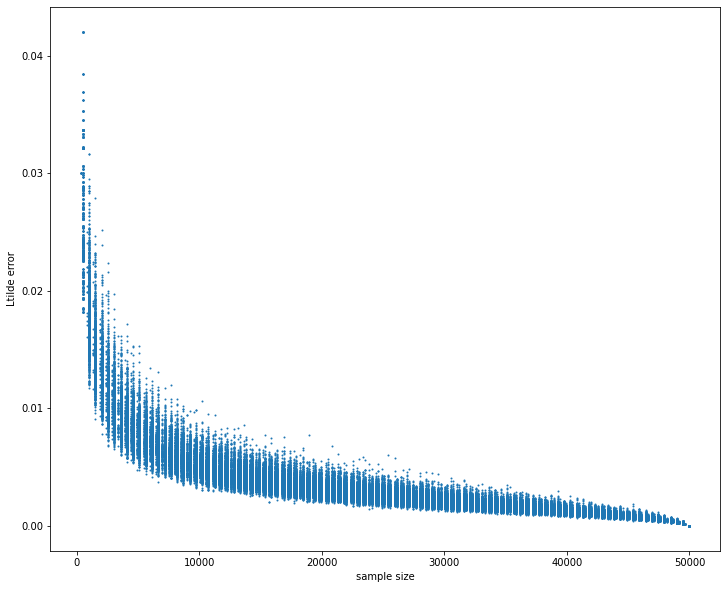

In [35]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

Text(0, 0.5, 'Ltilde error')

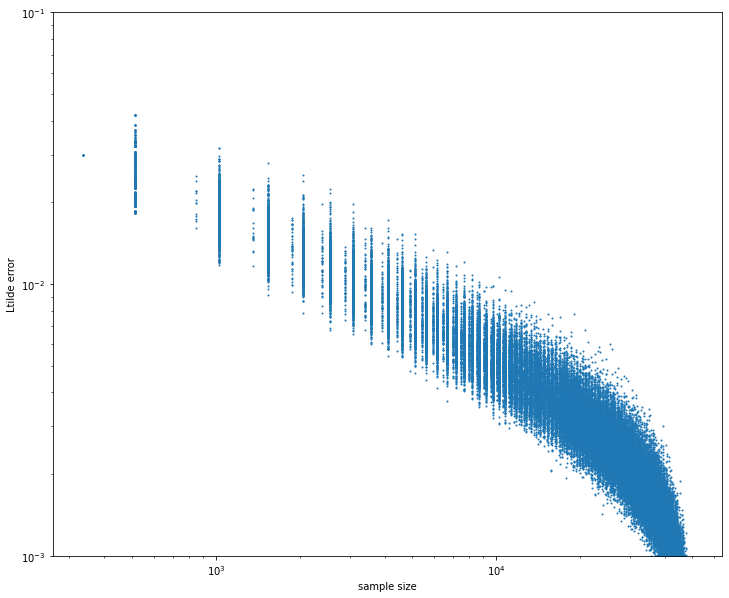

In [36]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

In [37]:
def calculate_mean(size_arr,err_arr):
    size_err = {}
    
    for i in range(len(size_arr)):
        if size_arr[i] not in size_err:
            size_err[size_arr[i]] = [err_arr[i],]
        else:
            size_err[size_arr[i]].append(err_arr[i])
    
    size_arr_,err_arr_ = [],[]
    
    for size in size_err:
        size_err[size] = np.array(size_err[size])
        #size_err[size] = (size_err[size].mean(),size_err[size].std())
        
        size_arr_.append(size)
        err_arr_.append(size_err[size].mean())
    
    return size_arr_,err_arr_
clado_sizes_mean,clado_err_mean = calculate_mean(clado_sizes,Ltilde_errors)

In [51]:
clado_sizes_mean,clado_err_mean = np.array(clado_sizes_mean),np.array(clado_err_mean)

In [53]:
clado_sizes_mean, clado_err_mean = clado_sizes_mean[np.argsort(clado_sizes_mean)],clado_err_mean[np.argsort(clado_sizes_mean)]

Text(0, 0.5, 'Ltilde error')

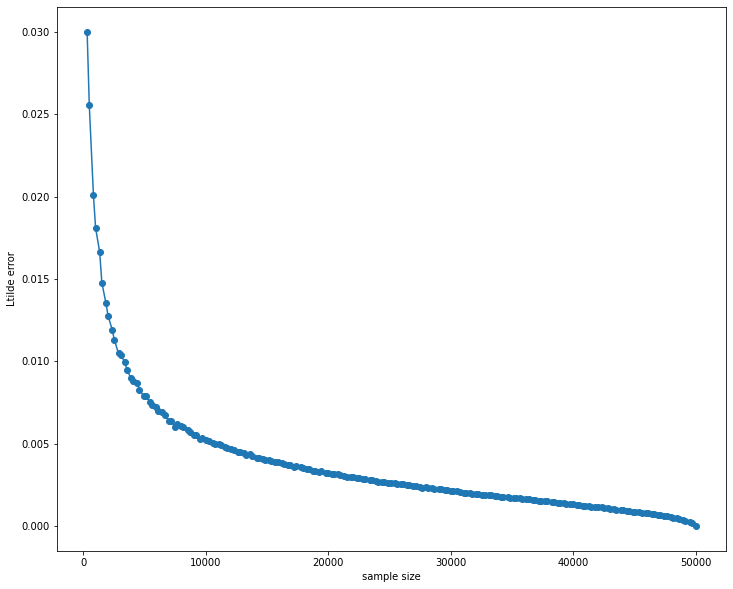

In [55]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

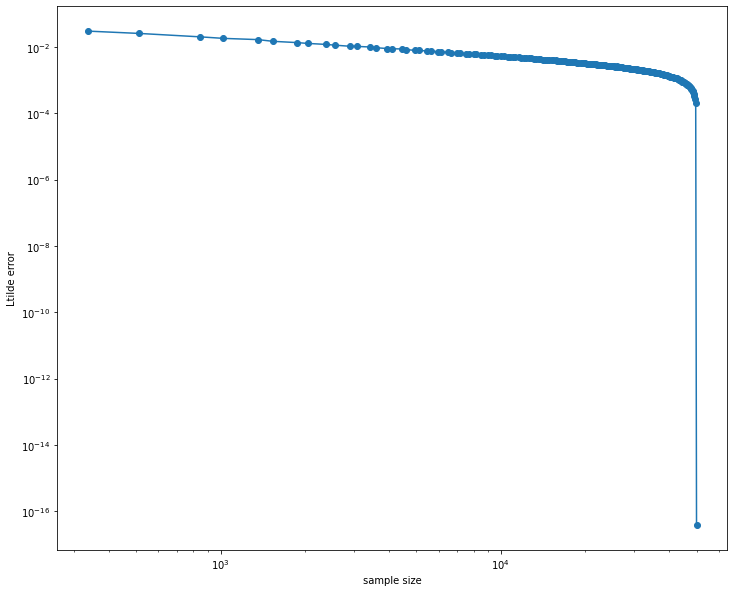

In [56]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')

(0.001, 0.1)

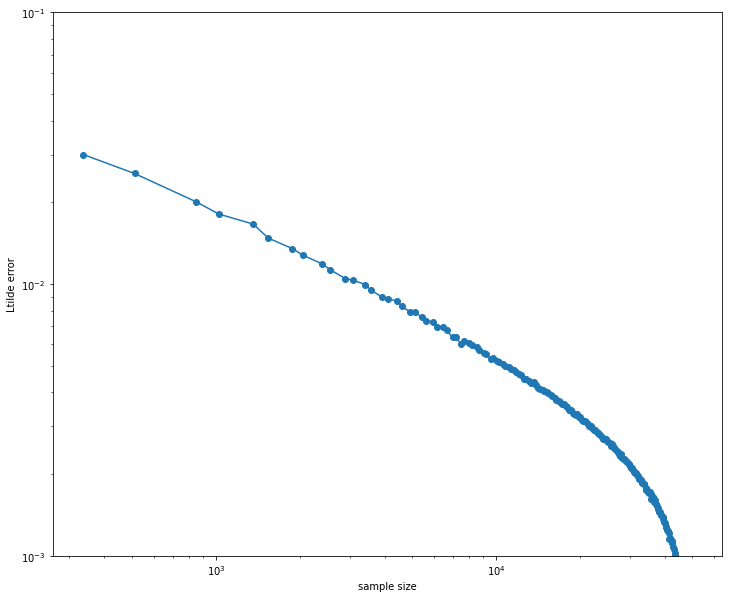

In [57]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])

In [58]:
class layer_hook(object):

    def __init__(self):
        super(layer_hook, self).__init__()
        self.in_shape = None
        self.out_shape = None

    def hook(self, module, inp, outp):
        self.in_shape = inp[0].size()
        self.out_shape = outp.size()
    

hooks = {}

for layer in ref_layer_index:
    m = getModuleByName(model,layer[:-10])
    hook = layer_hook()
    hooks[layer[:-10]] = (hook,m.register_forward_hook(hook.hook))

In [59]:
with torch.no_grad():
    for img,label in train:
        model(img.cuda())
        break

In [60]:
def get_layer_bitops(layer_name,a_bits,w_bits):
    
    m = getModuleByName(model,layer_name)
    
    if isinstance(m,torch.nn.Conv2d):
        _,cin,_,_ = hooks[layer_name][0].in_shape
        _,cout,hout,wout = hooks[layer_name][0].out_shape
        
        n_muls = cin * m.weight.size()[2] * m.weight.size()[3] * cout * hout * wout
        n_accs = (cin * m.weight.size()[2] * m.weight.size()[3] - 1) * cout * hout * wout
        
        #bitops_per_mul = 2 * a_bits * w_bits
        #bitops_per_acc = (a_bits + w_bits) + np.ceil(np.log2(cin * m.weight.size()[2] * m.weight.size()[3]))
        
        bitops_per_mul = 5*a_bits*w_bits - 5*a_bits-3*w_bits+3
        bitops_per_acc = 3*a_bits + 3*w_bits + 29
        
        return n_muls * bitops_per_mul + n_accs * bitops_per_acc

In [63]:
L = true_Ltilde.shape[0]
layer_size = np.array([0 for i in range(L)])
layer_bitops = np.array([0 for i in range(L)])
for l in ref_layer_index:
    index = ref_layer_index[l]
    layer_name, scheme = index2layerscheme[index]
    a_bits,w_bits = eval(scheme[:-4])
    #print(layer_name,a_bits,w_bits)
    layer_size[index] = torch.numel(getModuleByName(model,layer_name).weight) * int(w_bits)
    layer_bitops[index] = get_layer_bitops(layer_name,a_bits,w_bits)

NameError: name 'index2layerscheme' is not defined

In [ ]:
def evaluate_decision(v,printInfo=False,test=test):
    global mqb_mix_model
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(aw_scheme)),dtype=int) * len(aw_scheme)
    offset = offset.cumsum(dim=-1) - len(aw_scheme)
    select = v.reshape(-1,len(aw_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    bitops = (layer_bitops[select]).sum()/10**9
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = index2layerscheme[scheme_id]
        decisions[layer] = eval(scheme[:-4])
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        
        # perturb layers
        perturb(decisions)
            
        # do evaluation
        res = evaluate(test,mqb_mix_model)
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
    return res,modelsize,bitops

In [ ]:
import cvxpy as cp

def MIQCP_optimize(cached_grad,layer_bitops,layer_size,
                   schemes_per_layer=3,
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True):
    
    if cached_grad.__class__ == torch.Tensor:
        cached_grad = cached_grad.cpu().numpy()
    
    
    x = cp.Variable(cached_grad.shape[0], boolean=True)
    schemes_per_layer = schemes_per_layer
    assert cached_grad.shape[0]%schemes_per_layer == 0, 'cached_gradient shape[0] does not divde schemes per layer'
    num_layers = cached_grad.shape[0]//schemes_per_layer
    
    if not naive:
        # convexation of cached_grad
        es,us = np.linalg.eig(cached_grad)
        if PSD:
            es[es<0] = 0
        C = us@np.diag(es)@us.T
        C = cp.atoms.affine.wraps.psd_wrap(C)
        objective = cp.Minimize(cp.quad_form(x,C))
    else:
        objective = cp.Minimize(np.diagonal(cached_grad)@x)

    equality_constraint_matrix = []
    for i in range(num_layers):
        col = np.zeros(cached_grad.shape[0])
        col[i*schemes_per_layer:(i+1)*schemes_per_layer] = 1
        equality_constraint_matrix.append(col)

    equality_constraint_matrix = np.array(equality_constraint_matrix)

    constraints = [equality_constraint_matrix@x == np.ones((num_layers,)),
                   layer_bitops@x/10**9<=bitops_bound,
                   layer_size@x/8/1024/1024<=size_bound]

    prob = cp.Problem(objective,constraints)
    prob.solve(verbose=False,
               TimeLimit=10,solver='GUROBI')
    
    # Print result.
    print(prob.status)
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    #print(f"bitops: {x.value@layer_bitops}")
    return x

In [ ]:
cached_grad = np.zeros_like(true_Ltilde)
for i in range(cached_grad.shape[0]):
    for j in range(cached_grad.shape[0]):
        layer_i,scheme_i = ref_index2layerscheme[i]
        layer_j,scheme_j = ref_index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                cached_grad[i,j] = cached_grad[j,i] = 2 * true_Ltilde[i,j]
            else:
                cached_grad[i,j] = cached_grad[j,i] = 0
        else:
            cached_grad[i,j] = cached_grad[j,i] = true_Ltilde[i,j] - true_Ltilde[i,i] - true_Ltilde[j,j]

v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=True,PSD=True)
v = torch.Tensor(v.value)
evaluate_decision(v)

In [ ]:
v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True)
v = torch.Tensor(v.value)
evaluate_decision(v)

In [ ]:
# 'layer2.0.conv1' is the one where linear objective fails



In [ ]:
for n_batches in (1,2,4,8,16,32,64):
    
    for sid in range(5):
        
        print(f'{n_batches} batches, sid {sid}')
    
        shuffle = np.random.choice(98,n_batches,replace=False)

        new_batch_size = batch_size[shuffle]

        new_batch_Ltildes = batch_Ltildes[shuffle]

        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)

        n_samples = new_batch_size.sum()

        est_Ltilde /= n_samples

        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        # calculate est ltilde
        
        cached_grad = np.zeros_like(est_Ltilde)
        
        for i in range(cached_grad.shape[0]):
            for j in range(cached_grad.shape[0]):
                layer_i,scheme_i = ref_index2layerscheme[i]
                layer_j,scheme_j = ref_index2layerscheme[j]
                if layer_i == layer_j:
                    if scheme_i == scheme_j:
                        cached_grad[i,j] = cached_grad[j,i] = 2 * est_Ltilde[i,j]
                    else:
                        cached_grad[i,j] = cached_grad[j,i] = 0
                else:
                    cached_grad[i,j] = cached_grad[j,i] = est_Ltilde[i,j] - est_Ltilde[i,i] - est_Ltilde[j,j]
        
        
        res = {}
        
        res['batches'] = shuffle
        res['est_Ltilde'] = est_Ltilde
        res['n_samples'] = n_samples
        res['Ltilde_error'] = diff
        res['clado_perf'],res['clado_size'] = [],[]
        res['naive_perf'],res['naive_size'] = [],[]
        
        for size_bound in np.linspace(0.125,0.2563,100):
            
            print(f'size bound {size_bound:.4f}MB')
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=False,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['clado_perf'].append(perf)
            res['clado_size'].append(size)
            
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=True,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['naive_perf'].append(perf)
            res['naive_size'].append(size)
        
        with open(f'{n_batches}batches_sid{sid}.pkl','wb') as f:
            pickle.dump(res,f)
        
        
    
    
    

In [ ]:
for n_batches in (98,):
    
    for sid in range(1):
        
        print(f'{n_batches} batches, sid {sid}')
    
        shuffle = np.random.choice(98,n_batches,replace=False)

        new_batch_size = batch_size[shuffle]

        new_batch_Ltildes = batch_Ltildes[shuffle]

        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)

        n_samples = new_batch_size.sum()

        est_Ltilde /= n_samples

        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        # calculate est ltilde
        
        cached_grad = np.zeros_like(est_Ltilde)
        
        for i in range(cached_grad.shape[0]):
            for j in range(cached_grad.shape[0]):
                layer_i,scheme_i = ref_index2layerscheme[i]
                layer_j,scheme_j = ref_index2layerscheme[j]
                if layer_i == layer_j:
                    if scheme_i == scheme_j:
                        cached_grad[i,j] = cached_grad[j,i] = 2 * est_Ltilde[i,j]
                    else:
                        cached_grad[i,j] = cached_grad[j,i] = 0
                else:
                    cached_grad[i,j] = cached_grad[j,i] = est_Ltilde[i,j] - est_Ltilde[i,i] - est_Ltilde[j,j]
        
        
        res = {}
        
        res['batches'] = shuffle
        res['est_Ltilde'] = est_Ltilde
        res['n_samples'] = n_samples
        res['Ltilde_error'] = diff
        res['clado_perf'],res['clado_size'] = [],[]
        res['naive_perf'],res['naive_size'] = [],[]
        
        for size_bound in np.linspace(0.125,0.2563,100):
            
            print(f'size bound {size_bound:.4f}MB')
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=False,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['clado_perf'].append(perf)
            res['clado_size'].append(size)
            
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=True,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['naive_perf'].append(perf)
            res['naive_size'].append(size)
        
        with open(f'{n_batches}batches_sid{sid}.pkl','wb') as f:
            pickle.dump(res,f)

## Visualize the optimization results under different CLADO sample sizes 

In [ ]:
def plot(pklfile,xlim=None,ylim=None):
    with open(pklfile,'rb') as f:
        res = pickle.load(f)
    
    clado_acc = [res['clado_perf'][i]['top1'].cpu().numpy() for i in range(len(res['clado_perf']))]
    
    naive_acc = [res['naive_perf'][i]['top1'].cpu().numpy()  for i in range(len(res['clado_perf']))]
    
    
    plt.plot(res['clado_size'],clado_acc,label=f'{pklfile}-clado',marker='o',linewidth=0.5)
    plt.plot(res['naive_size'],naive_acc,label=f'{pklfile}-naive',marker='o',linewidth=0.5)
    plt.legend()
    plt.xlabel('size')
    plt.ylabel('accuracy')
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)

In [ ]:
xlim=[0.2,0.26]
ylim=[66,69]
ref_group = 2

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plt.show()

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid1.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid2.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid3.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid4.pkl',xlim=xlim,ylim=ylim)
plt.show()

for sid in range(5):
    plt.clf()
    plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
    plot(f'{ref_group}batches_sid{sid}.pkl',xlim=xlim,ylim=ylim)
    plt.show()

In [ ]:
xlim=[0.2,0.26]
ylim=[66,69]
ref_group = 16

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plt.show()

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid1.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid2.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid3.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid4.pkl',xlim=xlim,ylim=ylim)
plt.show()

for sid in range(5):
    plt.clf()
    plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
    plot(f'{ref_group}batches_sid{sid}.pkl',xlim=xlim,ylim=ylim)
    plt.show()

In [ ]:
xlim=[0.2,0.26]
ylim=[66,69]
ref_group = 32

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plt.show()

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid1.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid2.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid3.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid4.pkl',xlim=xlim,ylim=ylim)
plt.show()

for sid in range(5):
    plt.clf()
    plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
    plot(f'{ref_group}batches_sid{sid}.pkl',xlim=xlim,ylim=ylim)
    plt.show()

In [ ]:
xlim=[0.2,0.26]
ylim=[66,69]
ref_group = 64

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plt.show()

plt.clf()
plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid0.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid1.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid2.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid3.pkl',xlim=xlim,ylim=ylim)
plot(f'{ref_group}batches_sid4.pkl',xlim=xlim,ylim=ylim)
plt.show()

for sid in range(5):
    plt.clf()
    plot('98batches_sid0.pkl',xlim=xlim,ylim=ylim)
    plot(f'{ref_group}batches_sid{sid}.pkl',xlim=xlim,ylim=ylim)
    plt.show()

In [ ]:
#plot('98batches_sid0.pkl')
for sid in range(5):
    plt.clf()
    plot(f'2batches_sid{sid}.pkl')
    plt.show()

In [ ]:
plot('2batches_sid0.pkl')